In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [2]:
url = "https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=24h&id=4151"
headers = {
    "User-Agent": "Timeseries Data Science Coding Project (Limited Use)"
}
response = requests.get(url, headers=headers)

In [3]:
# Check the response status
if response.status_code == 200:
    data = response.json()
    print("Data received:")
    print(data)
else:
    print(f"Request failed with status code {response.status_code}")
    print(response.text)

Data received:
{'data': [{'timestamp': 1726272000, 'avgHighPrice': 1383870, 'avgLowPrice': 1369589, 'highPriceVolume': 3042, 'lowPriceVolume': 3162}, {'timestamp': 1726358400, 'avgHighPrice': 1385410, 'avgLowPrice': 1371527, 'highPriceVolume': 3408, 'lowPriceVolume': 3396}, {'timestamp': 1726444800, 'avgHighPrice': 1379225, 'avgLowPrice': 1366332, 'highPriceVolume': 2589, 'lowPriceVolume': 2791}, {'timestamp': 1726531200, 'avgHighPrice': 1377825, 'avgLowPrice': 1364310, 'highPriceVolume': 2464, 'lowPriceVolume': 2429}, {'timestamp': 1726617600, 'avgHighPrice': 1364807, 'avgLowPrice': 1350344, 'highPriceVolume': 2489, 'lowPriceVolume': 2585}, {'timestamp': 1726704000, 'avgHighPrice': 1352537, 'avgLowPrice': 1334905, 'highPriceVolume': 2643, 'lowPriceVolume': 2658}, {'timestamp': 1726790400, 'avgHighPrice': 1346681, 'avgLowPrice': 1333681, 'highPriceVolume': 2730, 'lowPriceVolume': 2701}, {'timestamp': 1726876800, 'avgHighPrice': 1344650, 'avgLowPrice': 1330791, 'highPriceVolume': 3228, 

In [4]:
full_item_df = pd.json_normalize(data['data'])

In [5]:
full_item_df['timestamp'] = pd.to_datetime(full_item_df['timestamp'], unit='s', utc=True)
full_item_df['date'] = full_item_df['timestamp'].dt.date

In [6]:
item_df = full_item_df[['date', 'avgHighPrice']]
item_df['date'] = pd.to_datetime(item_df['date'])
item_df.set_index('date', inplace=True)
print(item_df)

            avgHighPrice
date                    
2024-09-14       1383870
2024-09-15       1385410
2024-09-16       1379225
2024-09-17       1377825
2024-09-18       1364807
...                  ...
2025-09-09       1526973
2025-09-10       1517705
2025-09-11       1520567
2025-09-12       1526206
2025-09-13       1517968

[365 rows x 1 columns]


<ipython-input-6-c3e532aea555>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_df['date'] = pd.to_datetime(item_df['date'])


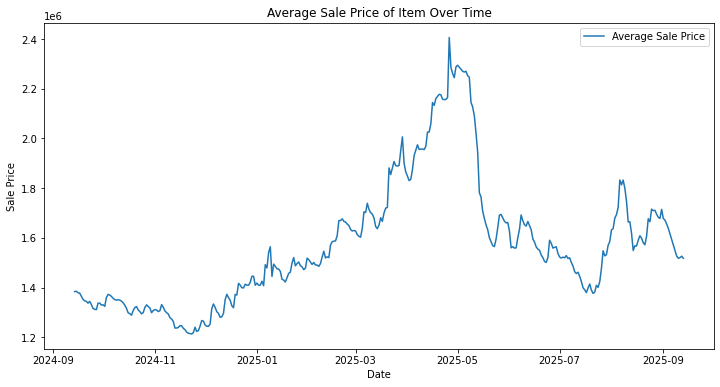

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(item_df['avgHighPrice'], label='Average Sale Price')
plt.title('Average Sale Price of Item Over Time')
plt.xlabel('Date')
plt.ylabel('Sale Price')
plt.legend()
plt.show()

# Test One 10 Day Prediction

In [9]:
item_df_train = item_df.iloc[:-10]
item_df_test = item_df.iloc[-10:]

print(item_df_train.size)
print(item_df_test.size)

355
10


In [11]:
model = auto_arima(
    item_df_train['avgHighPrice'],
    seasonal=True,
    m=1,          # <<<<< This is the key change
    trace=True,  
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8375.712, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8369.050, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8370.414, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8370.437, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8367.247, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8371.854, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds


In [13]:
n_periods = 10
forecast = model.predict(n_periods=n_periods)
forecast.index = item_df_test.index
print(forecast)

date
2025-09-04    1655933.0
2025-09-05    1655933.0
2025-09-06    1655933.0
2025-09-07    1655933.0
2025-09-08    1655933.0
2025-09-09    1655933.0
2025-09-10    1655933.0
2025-09-11    1655933.0
2025-09-12    1655933.0
2025-09-13    1655933.0
dtype: float64


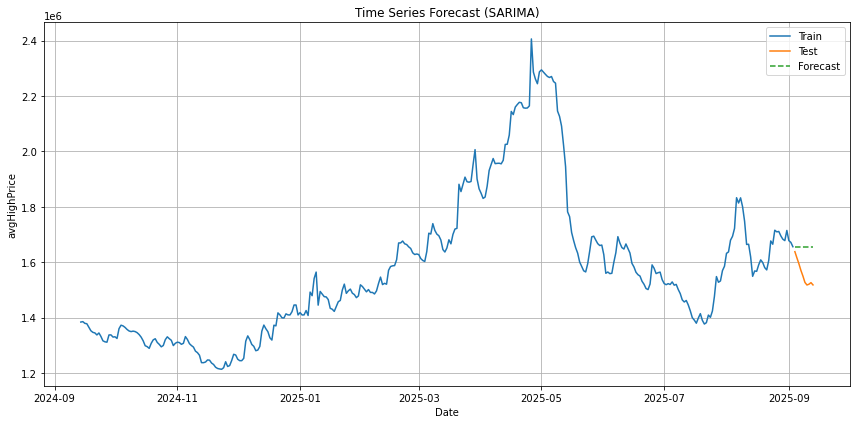

In [14]:
plt.figure(figsize=(12,6))
plt.plot(item_df_train.index, item_df_train['avgHighPrice'], label='Train')
plt.plot(item_df_test.index, item_df_test['avgHighPrice'], label='Test')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('avgHighPrice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test Two 30 Day Prediction

In [15]:
item_df_train = item_df.iloc[:-30]
item_df_test = item_df.iloc[-30:]

print(item_df_train.size)
print(item_df_test.size)

335
30


In [16]:
model = auto_arima(
    item_df_train['avgHighPrice'],
    seasonal=True,
    m=2,
    trace=True,  
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=7909.801, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=7903.425, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=7906.108, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=7906.111, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=7901.501, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[2] intercept   : AIC=7904.746, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[2] intercept   : AIC=7904.738, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[2] intercept   : AIC=7906.699, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[2] intercept   : AIC=7904.737, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=7904.759, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=7906.036, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[2]          
Total fit time: 0.709 seconds


In [17]:
n_periods = 30
forecast = model.predict(n_periods=n_periods)
forecast.index = item_df_test.index
print(forecast)

date
2025-08-15    1549034.0
2025-08-16    1549034.0
2025-08-17    1549034.0
2025-08-18    1549034.0
2025-08-19    1549034.0
2025-08-20    1549034.0
2025-08-21    1549034.0
2025-08-22    1549034.0
2025-08-23    1549034.0
2025-08-24    1549034.0
2025-08-25    1549034.0
2025-08-26    1549034.0
2025-08-27    1549034.0
2025-08-28    1549034.0
2025-08-29    1549034.0
2025-08-30    1549034.0
2025-08-31    1549034.0
2025-09-01    1549034.0
2025-09-02    1549034.0
2025-09-03    1549034.0
2025-09-04    1549034.0
2025-09-05    1549034.0
2025-09-06    1549034.0
2025-09-07    1549034.0
2025-09-08    1549034.0
2025-09-09    1549034.0
2025-09-10    1549034.0
2025-09-11    1549034.0
2025-09-12    1549034.0
2025-09-13    1549034.0
dtype: float64


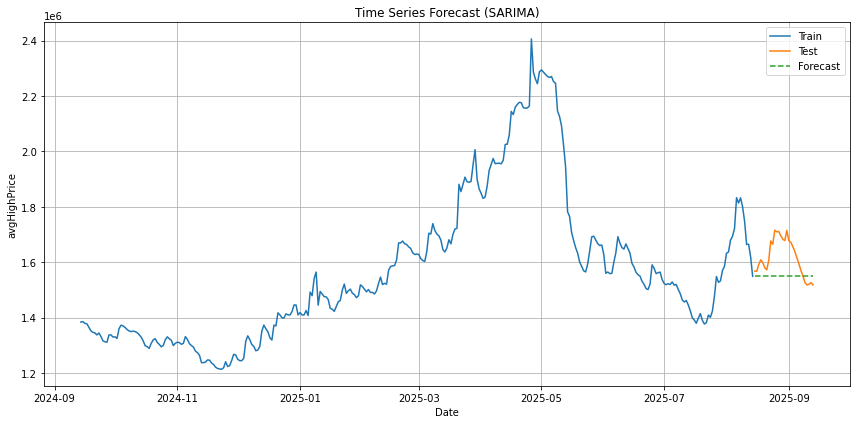

In [18]:
plt.figure(figsize=(12,6))
plt.plot(item_df_train.index, item_df_train['avgHighPrice'], label='Train')
plt.plot(item_df_test.index, item_df_test['avgHighPrice'], label='Test')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('avgHighPrice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
item_df_train = item_df.iloc[:-90]
item_df_test = item_df.iloc[-90:]

print(item_df_train.size)
print(item_df_test.size)

275
90


In [20]:
model = auto_arima(
    item_df_train['avgHighPrice'],
    seasonal=True,
    m=30,
    trace=True,  
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=6501.361, Time=2.70 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=6489.912, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=6493.693, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=6493.716, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=6488.060, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=6491.880, Time=0.21 sec
 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=6491.879, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[30] intercept   : AIC=6493.833, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=6491.722, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=6491.746, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=6493.540, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[30]          
Total fit time: 4.477 seconds


In [21]:
n_periods = 90
forecast = model.predict(n_periods=n_periods)
forecast.index = item_df_test.index
print(forecast)

date
2025-06-16    1595778.0
2025-06-17    1595778.0
2025-06-18    1595778.0
2025-06-19    1595778.0
2025-06-20    1595778.0
                ...    
2025-09-09    1595778.0
2025-09-10    1595778.0
2025-09-11    1595778.0
2025-09-12    1595778.0
2025-09-13    1595778.0
Length: 90, dtype: float64


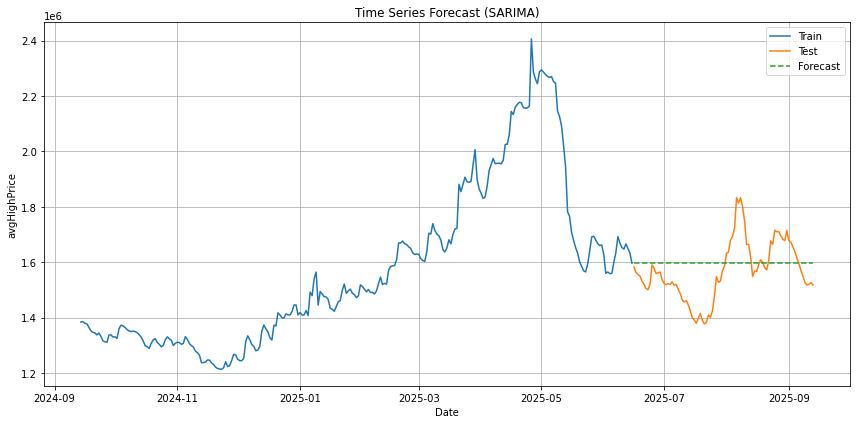

In [22]:
plt.figure(figsize=(12,6))
plt.plot(item_df_train.index, item_df_train['avgHighPrice'], label='Train')
plt.plot(item_df_test.index, item_df_test['avgHighPrice'], label='Test')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('avgHighPrice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()